# Traffic accident occurrence prediction task

Code of the following paper: 

Traffic Accident Prediction using Graph Neural Networks: New Datasets and the TRAVEL Model. Baixiang Huang, Bryan Hooi.

In [1]:
# Run this cell if you are using google colab, and restart the runtime to use the correct version of matplotlib
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install -q osmnx
# !python -m pip uninstall matplotlib -y
# !pip install matplotlib==3.1.1

In [2]:
import os
import math
import time
import shutil
import pickle
import numpy as np
import osmnx as ox
import pandas as pd
import os.path as osp
import networkx as nx
import xgboost as xgb
import matplotlib.pyplot as plt

import torch
import torch_geometric
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

from torch import Tensor
from torch.nn import Parameter
from torch_geometric.io import read_npz
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import reset, uniform, zeros
from torch_geometric.typing import OptTensor, OptPairTensor, Adj, Size
from torch_geometric.data import Data, DataLoader, InMemoryDataset, download_url

from pylab import cm
from matplotlib import colors
from IPython.display import clear_output
from xgboost.sklearn import XGBClassifier
from typing import Union, Tuple, Callable, Optional
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, roc_auc_score

np.random.seed(7)
torch.manual_seed(7)
plt.style.use("ggplot")

In [3]:
print(torch.__version__, torch.version.cuda, torch_geometric.__version__)

1.10.0 10.2 2.0.2


In [4]:
def read_npz(path):
    with np.load(path, allow_pickle=True) as f:
        return parse_npz(f)


def parse_npz(f):
    x = torch.from_numpy(f['x']).to(torch.float)
    y = torch.from_numpy(f['y']).to(torch.long)
    edge_attr = torch.from_numpy(f['edge_attr']).to(torch.float)
    edge_index = torch.from_numpy(f['edge_index']).to(torch.long).t().contiguous()
    edge_attr_dir = torch.from_numpy(f['edge_attr_dir']).to(torch.float)
    edge_attr_ang = torch.from_numpy(f['edge_attr_ang']).to(torch.float)
    coords = torch.from_numpy(f['coordinates']).to(torch.float)
    severity_labels = torch.from_numpy(f['severity_labels']).to(torch.long)
    return Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_attr, 
                edge_attr_dir=edge_attr_dir, edge_attr_ang=edge_attr_ang, 
                coords=coords, severity_labels=severity_labels)


def train_test_split_stratify(dataset, train_ratio, val_ratio, class_num):
    labels = dataset[0].y
    train_mask = torch.zeros(size=labels.shape, dtype=bool)
    val_mask = torch.zeros(size=labels.shape, dtype=bool)
    test_mask = torch.zeros(size=labels.shape, dtype=bool)
    for i in range(class_num):
        stratify_idx = np.argwhere(labels.numpy() == i).flatten()
        np.random.shuffle(stratify_idx)
        split1 = int(len(stratify_idx) * train_ratio)
        split2 = split1 + int(len(stratify_idx) * val_ratio)
        train_mask[stratify_idx[:split1]] = True 
        val_mask[stratify_idx[split1:split2]] = True
        test_mask[stratify_idx[split2:]] = True
    highest = pd.DataFrame(labels).value_counts().head().iloc[0]
    # print("Null Accuracy:", highest / (len(labels)))
    return train_mask, val_mask, test_mask

In [5]:
class TRAVELDataset(InMemoryDataset):
    r"""
    Args:
        root (string): Root directory where the dataset should be saved.
        name (string): The name of the dataset.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    """
    url = 'https://github.com/baixianghuang/travel/raw/main/dataset/{}.npz'
    
    def __init__(self, root: str, name: str,
                 transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        self.name = name.lower()
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_dir(self) -> str:
        return osp.join(self.root, self.name, 'raw')

    @property
    def processed_dir(self) -> str:
        return osp.join(self.root, self.name, 'processed')

    @property
    def raw_file_names(self) -> str:
        return f'{self.name}.npz'

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        download_url(self.url.format(self.name), self.raw_dir)

    def process(self):
        data = read_npz(self.raw_paths[0])
        data = data if self.pre_transform is None else self.pre_transform(data)
        data, slices = self.collate([data])
        torch.save((data, slices), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.name.capitalize()}Full()'

In [6]:
class TRAVELConv(MessagePassing):
    r"""
    Args:
        in_channels (int or tuple): Size of each input sample, or :obj:`-1` to
            derive the size from the first input(s) to the forward method.
            A tuple corresponds to the sizes of source and target
            dimensionalities.
        out_channels (int): Size of each output sample.
        nn (torch.nn.Module): Multiple layers of non-linear transformations 
            that maps feature data of shape :obj:`[-1,
            num_edge_features + num_edge_features]` to shape
            :obj:`[-1, new_dimension]`, *e.g.*, defined by
            :class:`torch.nn.Sequential`.
        aggr (string, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
            (default: :obj:`"add"`)
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add the transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(self, in_channels: Union[int, Tuple[int, int]],
                 out_channels: int, nn: Callable, aggr: str = 'add',
                 root_weight: bool = True, bias: bool = True, **kwargs):
        super(TRAVELConv, self).__init__(aggr=aggr, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.nn = nn
        self.aggr = aggr

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)
            
        self.in_channels_l = in_channels[0]

        if root_weight:
            self.root = Parameter(torch.Tensor(in_channels[1], out_channels))
        else:
            self.register_parameter('root', None)

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        reset(self.nn)
        if self.root is not None:
            uniform(self.root.size(0), self.root)
        zeros(self.bias)


    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, size: Size = None) -> Tensor:
        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        # propagate_type: (x: OptPairTensor, edge_attr: OptTensor)
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=size)

        x_r = x[1]
        if x_r is not None and self.root is not None:
            out += torch.matmul(x_r, self.root)

        if self.bias is not None:
            out += self.bias
        return out


    def message(self, x_i: Tensor, x_j: Tensor, edge_attr: Tensor) -> Tensor:
        inputs = torch.cat([x_j, edge_attr], dim=1)
        return self.nn(inputs)

    def __repr__(self):
        return '{}({}, {}, aggr="{}", nn={})'.format(self.__class__.__name__,
                                                     self.in_channels,
                                                     self.out_channels,
                                                     self.aggr, self.nn)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()
    

@torch.no_grad()
def test(model, data):
    model.eval()
    logits, measures = model().detach(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        mea = f1_score(data.y[mask].cpu(), pred.cpu(), average='binary')
        measures.append(mea)
        
    label_pred = logits.max(1)[1]
    mask = data.test_mask
    scores = logits[mask][:,1]
    pred = logits[mask].max(1)[1]
    test_y = data.y[mask]
    
    test_acc = pred.eq(test_y).sum().item() / mask.sum().item()
    test_map = average_precision_score(test_y.cpu(), scores.cpu())
    test_auc = roc_auc_score(test_y.cpu(), scores.cpu())
    return measures, label_pred, test_acc, test_map, test_auc


def train_loop(model, data, optimizer, num_epochs, model_name='test'):
    epochs, train_measures, valid_measures, test_measures, test_accs, test_maps, test_aucs = [], [], [], [], [], [], []
    for epoch in range(num_epochs):
        train(model, data, optimizer)
        log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
        measures, label_pred, test_acc, test_map, test_auc = test(model, data)
        train_mea, valid_mea, test_mea = measures
        epochs.append(epoch)
        train_measures.append(train_mea)
        valid_measures.append(valid_mea)
        test_measures.append(test_mea)
        test_aucs.append(test_auc)
        test_accs.append(test_acc)
        test_maps.append(test_map)
        
        if epoch % 20 == 0:
            clear_output(True)
            fig, (ax1, ax) = plt.subplots(1, 2, figsize=(30, 12))     
            gdf_pred['label'] = label_pred.cpu().numpy()
            for i in range(class_num):
                G = nx.MultiGraph()
                G.add_nodes_from(gdf_pred[gdf_pred['label'] == i].index)
                sub1 = nx.draw(G, pos=pos_dict, ax=ax1, node_color=color_ls[i], node_size=10)

            ax.text(1, 1, log.format(epoch, train_measures[-1], valid_measures[-1], test_measures[-1]), fontsize=18)
            ax.plot(epochs, train_measures, "r", epochs, valid_measures, "g", epochs, test_measures, "b")
            ax.set_ylim([0, 1])
            ax.legend(["train", "valid", "test"])  
            ax1.legend(["Negative", "Positive"])  
            ax1.set_title('('+str(cnt)+') '+ model_name, y=-0.01)
            plt.show()

    # Select idx from the second half period where the scores are more stable
    select_idx = np.argmax(valid_measures[num_epochs//2:]) + num_epochs//2  # test_measures
    final_test_mea = np.array(test_measures)[select_idx]
    final_test_auc = np.array(test_aucs)[select_idx]
    final_test_acc = np.array(test_accs)[select_idx]
    final_test_map = np.array(test_maps)[select_idx]

    print('Selected epoch {}'.format(select_idx))
    print('F1 {:.5f} | AUC {:.5f} | Test Acc {:.5f} | MAP {:.5f}'.format(final_test_mea, final_test_auc, final_test_acc, final_test_map))
    # draw_with_labels(gdf_pred, color_ls, model_name)
    return (round(final_test_mea,4), round(final_test_auc,4), round(final_test_acc,4), round(final_test_map,4))

## Load data

In [8]:
class_num = 2  # Accident occurrance prediction is a binary classification task
color_ls = []
cmap = cm.get_cmap('cool', class_num)
for i in range(class_num):
    rgba = cmap(i)   
    color_ls.append(colors.rgb2hex(rgba))
    
    
def draw_with_labels(df_nodes, model_name='test'):
    plt.figure(figsize=(6, 5)) 
    for i in range(class_num):
        G = nx.MultiGraph()
        G.add_nodes_from(df_nodes[df_nodes['label'] == i].index)
        nx.draw(G, pos=pos_dict, node_color=color_ls[i], node_size=3, label=i)
    plt.legend(labels=["Negative", "Positive"], loc="upper right", fontsize='small')
    plt.title('('+str(cnt)+') '+ model_name, y=-0.01)
    plt.show()

('Charlotte', 'NC')


Processing...
Done!


Number of graphs: 1
Number of node features: 10
Number of edge features: 19
Number of classes: 2
Number of nodes: 29364
Number of edges: 68403
Average node degree: 2.33
Contains isolated nodes: True
Contains self-loops: True
Is undirected: False


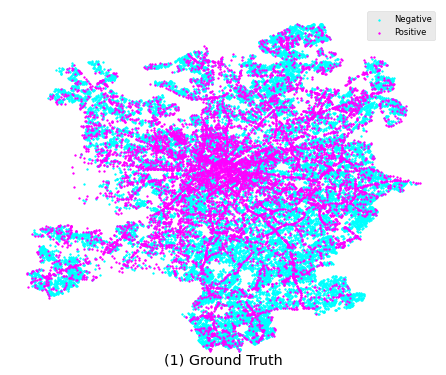

In [9]:
exp = [('Houston', 'TX'), ('Charlotte', 'NC'), ('Dallas', 'TX'), ('Austin', 'TX'),
       ('Los Angeles', 'CA'), ('Atlanta', 'GA'), ('Seattle', 'WA'), ('Chicago', 'IL')]
e = exp[1]
print(e)
cnt = 1

city_name, state_abbrev = e[0].lower().replace(" ", "_"), e[1].lower()
if os.path.exists('dataset/dataset_travel_all/exp/'+city_name+'_'+state_abbrev+'/processed'):
    shutil.rmtree('dataset/dataset_travel_all/exp/'+city_name+'_'+state_abbrev+'/processed')

dataset_city = TRAVELDataset('dataset/dataset_travel_all/exp/', city_name+'_'+state_abbrev) #city_name+'_'+state_abbrev
dataset = dataset_city
data = dataset_city[0]
class_num = dataset.num_classes
print(f'Number of graphs: {len(dataset)}')
print(f'Number of node features: {dataset.num_features}')
print(f'Number of edge features: {dataset.num_edge_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

# 60%, 20% and 20% for training, validation and test
data.train_mask, data.val_mask, data.test_mask = train_test_split_stratify(dataset_city, train_ratio=0.6, val_ratio=0.2, class_num=class_num)
sc = MinMaxScaler()
data.x[data.train_mask] = torch.tensor(sc.fit_transform(data.x[data.train_mask]), dtype=torch.float)
data.x[data.val_mask] = torch.tensor(sc.transform(data.x[data.val_mask]), dtype=torch.float)
data.x[data.test_mask] = torch.tensor(sc.transform(data.x[data.test_mask]), dtype=torch.float)
    
coords = data.coords.numpy()
gdf_pred = pd.DataFrame({'x': coords[:, 0], 'y': coords[:, 1], 'label': data.y.numpy()}) 
zip_iterator = zip(gdf_pred.index, gdf_pred[['x', 'y']].values)
pos_dict = dict(zip_iterator)
draw_with_labels(gdf_pred, 'Ground Truth')

edge_attr_all = MinMaxScaler().fit_transform(data.edge_attr.cpu()) 
edge_attr_all = torch.tensor(edge_attr_all).float().to(device)

# data = data.to(device)    

## Train

In [10]:
d = 16 # hidden dimension
cnt = 1
all_res = []
num_epochs = 301

In [11]:
X_train, X_test, y_train, y_test = data.x[data.train_mask].cpu().numpy(), data.x[data.test_mask].cpu().numpy(), data.y[data.train_mask].cpu().numpy(), data.y[data.test_mask].cpu().numpy()
start_time = time.time()
xgb_clf = XGBClassifier(use_label_encoder=False)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
test_acc, test_f1, test_map, test_auc = accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='binary'), average_precision_score(y_test, y_pred), roc_auc_score(y_test, y_pred)
print('f1_score {:.5f} | AUC {:.5f} | Test Accuracy {:.5f} | MAP {:.5f}'.format(test_f1, test_auc, test_acc, test_map))
res = (round(test_f1, 4), round(test_auc, 4), round(test_acc, 4), round(test_map, 4))
t = round(time.time() - start_time, 2)
all_res.append(('XGBoost',) + res + (t,))
print("Execution time: %.4f seconds" % t)

[20:59:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1_score 0.44889 | AUC 0.62955 | Test Accuracy 0.73749 | MAP 0.42727
Execution time: 0.3700 seconds


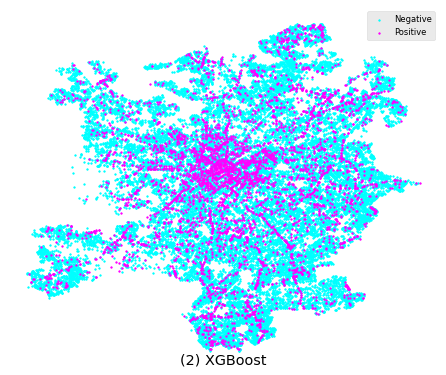

In [12]:
cnt += 1
y_pred_all = xgb_clf.predict(data.x.cpu().numpy())
coords = data.cpu().coords.numpy()
df_pred = pd.DataFrame({'x': coords[:, 0], 'y': coords[:, 1], 'label': y_pred_all}) 
draw_with_labels(df_pred, 'XGBoost')

In [13]:
data = data.to(device) 
device

device(type='cuda')

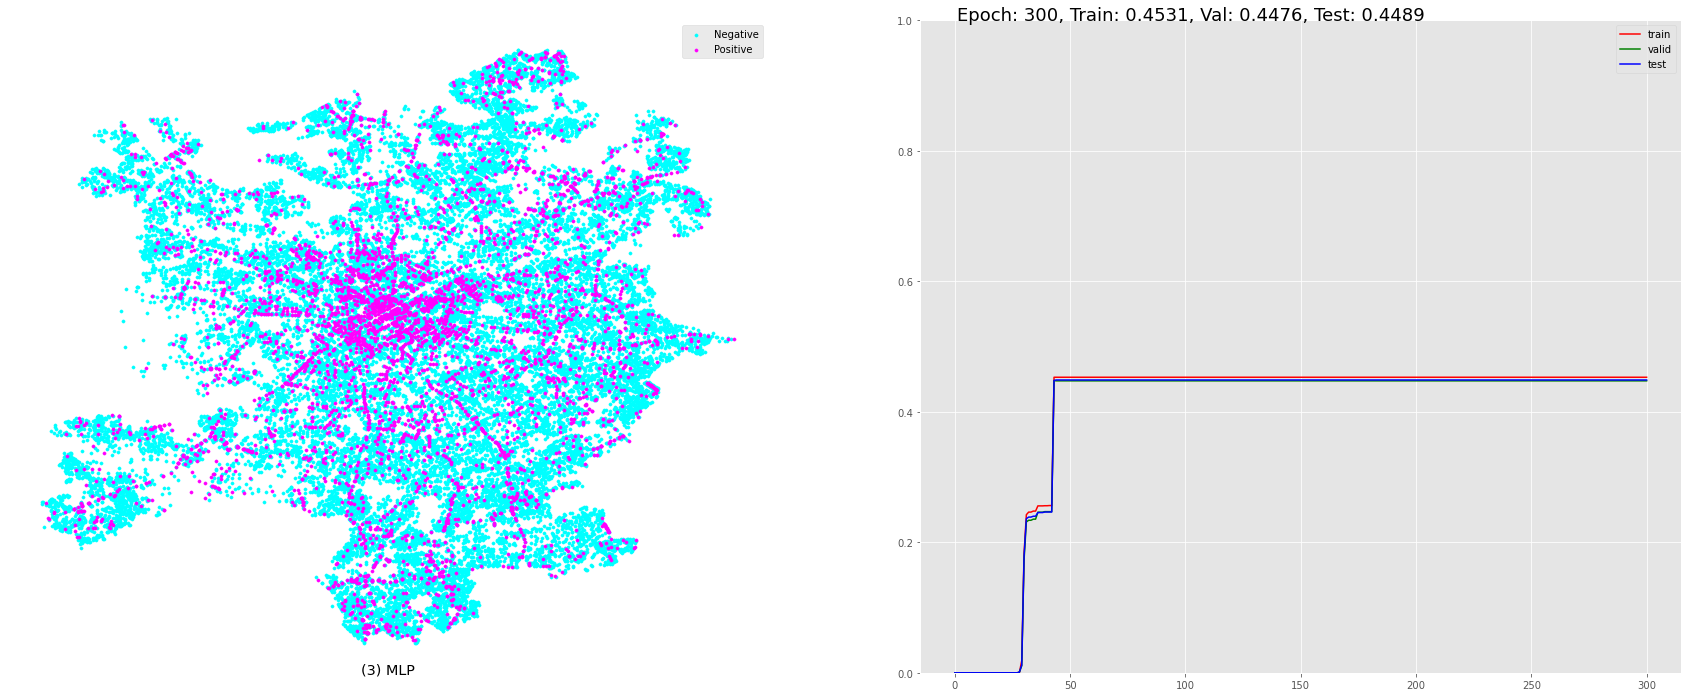

Selected epoch 150
F1 0.44889 | AUC 0.73683 | Test Acc 0.73749 | MAP 0.52680
Execution time: 18.0700 seconds


In [14]:
class MLP(nn.Module):
    def __init__(self, hidden_dim=d):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(dataset.num_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, dataset.num_classes)

    def forward(self):
        x = F.relu(self.fc1(data.x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


cnt += 1
start_time = time.time()
model = MLP().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'MLP')
t = round(time.time() - start_time, 2)
all_res.append(('MLP',) + res + (t,))
print("Execution time: %.4f seconds" % t)

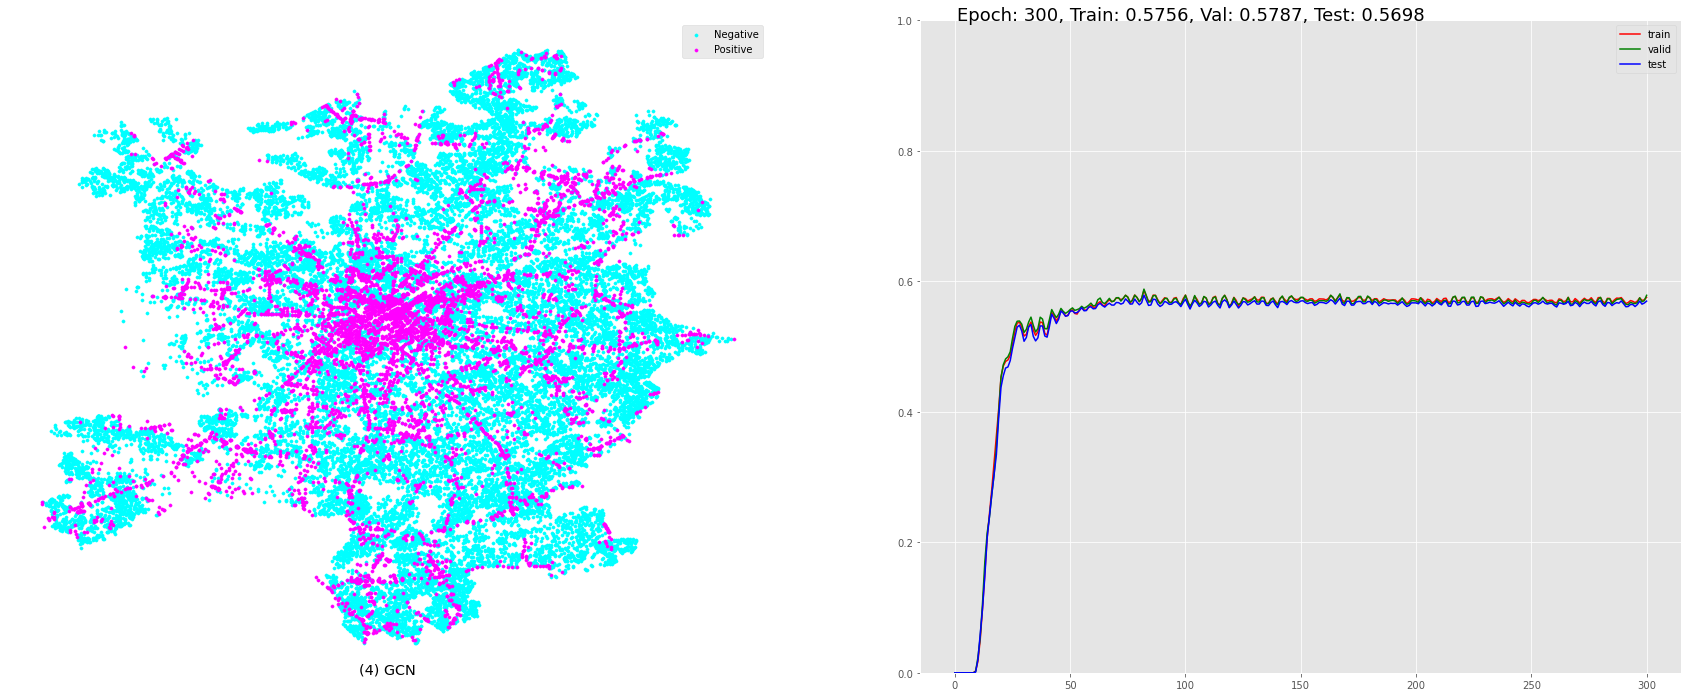

Selected epoch 167
F1 0.57436 | AUC 0.80408 | Test Acc 0.77392 | MAP 0.66671
Execution time: 15.5900 seconds


In [15]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_dim=d):
        super(GCN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(dataset.num_features, hidden_dim)
        self.conv2 = pyg_nn.GCNConv(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, dataset.num_classes)

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


cnt += 1
start_time = time.time()
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'GCN')
t = round(time.time() - start_time, 2)
all_res.append(('GCN',) + res + (t,))
print("Execution time: %.4f seconds" % t)

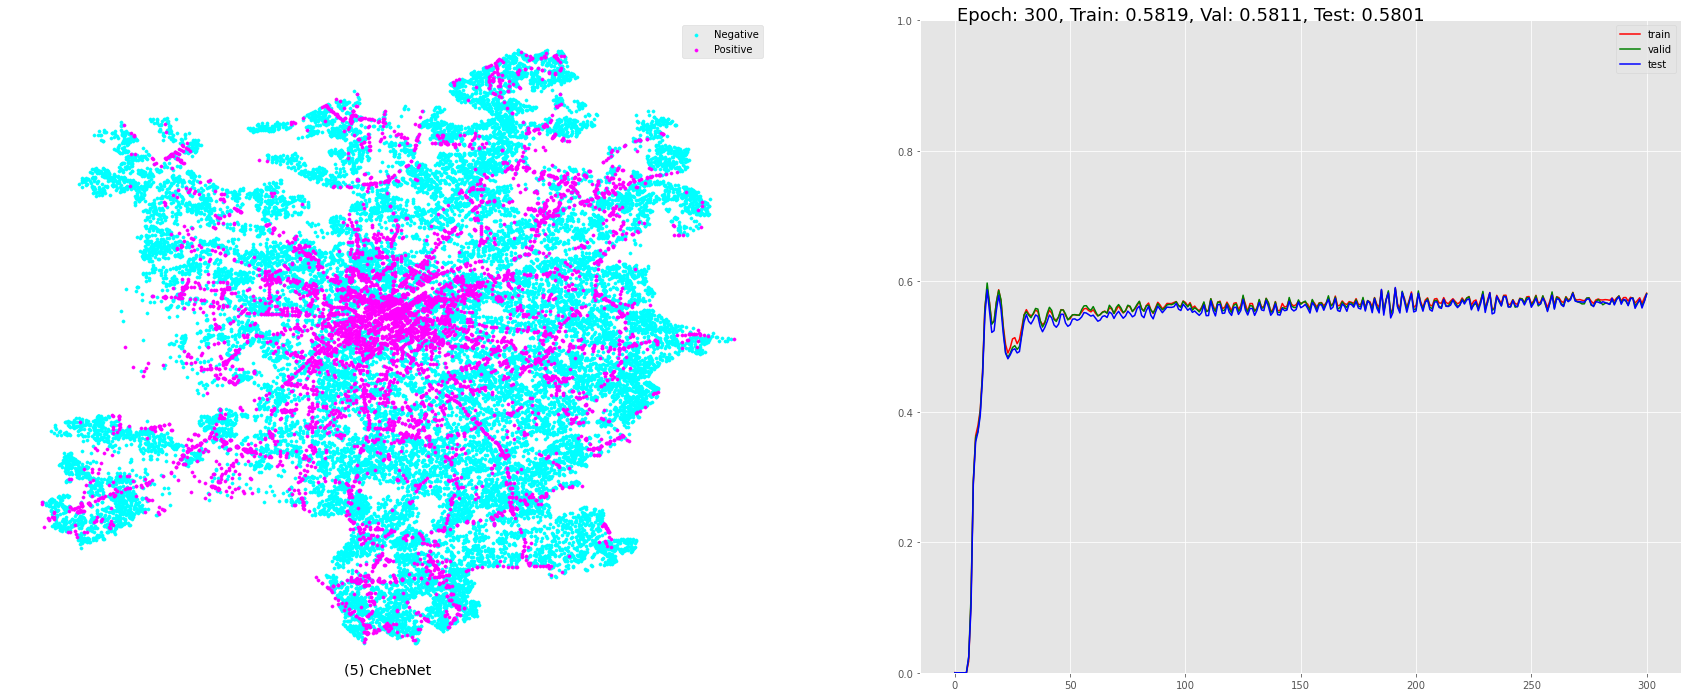

Selected epoch 191
F1 0.59068 | AUC 0.81043 | Test Acc 0.77869 | MAP 0.68213
Execution time: 16.1400 seconds


In [16]:
class ChebNet(torch.nn.Module):
    def __init__(self, hidden_dim=d):
        super(ChebNet, self).__init__()
        self.conv1 = pyg_nn.ChebConv(dataset.num_features, hidden_dim, K=2)
        self.conv2 = pyg_nn.ChebConv(hidden_dim, hidden_dim, K=2)
        self.fc1 = nn.Linear(hidden_dim, dataset.num_classes)

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


cnt += 1
start_time = time.time()
model = ChebNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'ChebNet')
t = round(time.time() - start_time, 2)
all_res.append(('ChebNet',) + res + (t,))
print("Execution time: %.4f seconds" % t)

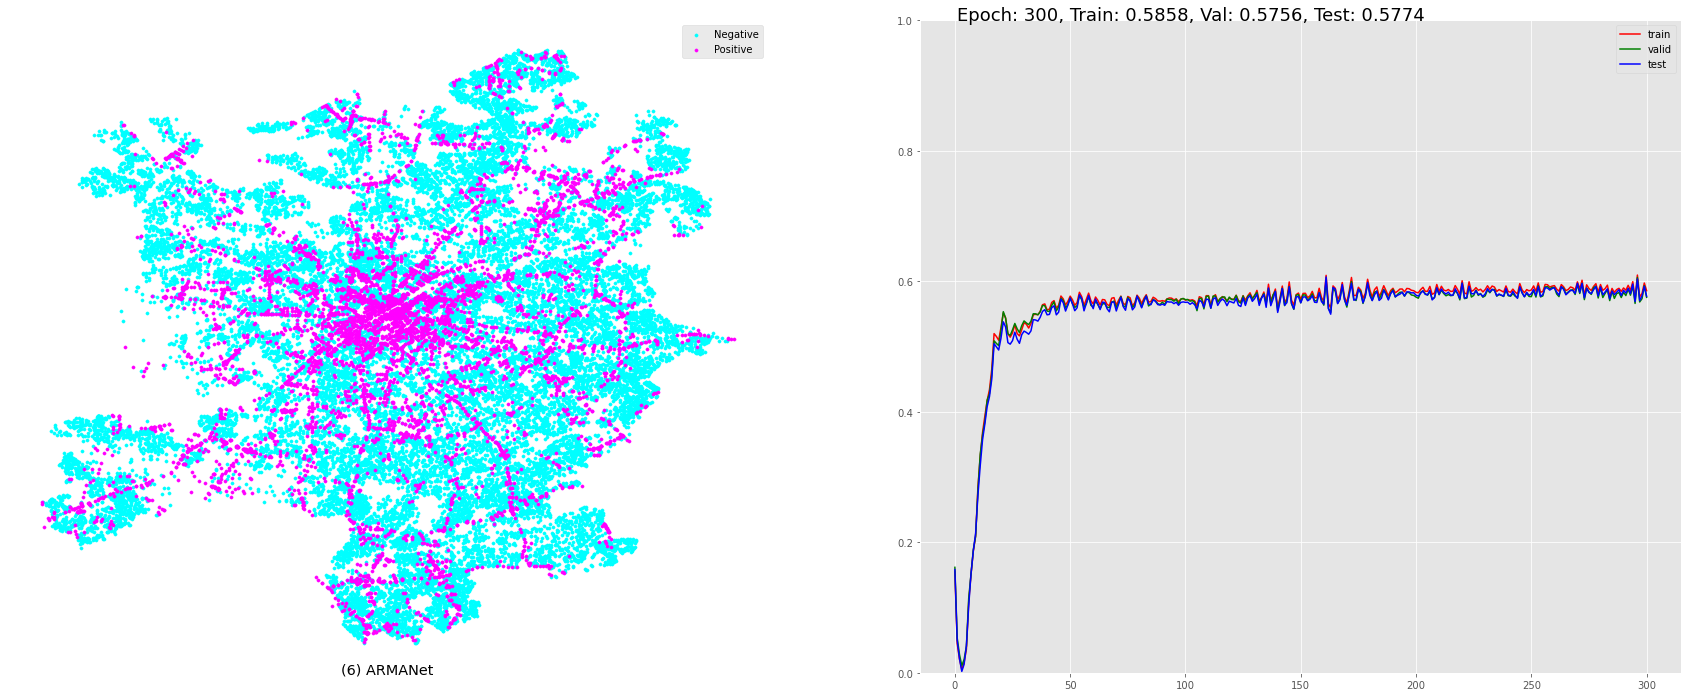

Selected epoch 296
F1 0.60373 | AUC 0.81224 | Test Acc 0.77920 | MAP 0.68564
Execution time: 14.9600 seconds


In [17]:
class ARMANet(torch.nn.Module):
    def __init__(self, hidden_dim=d):
        super(ARMANet, self).__init__()
        self.conv1 = pyg_nn.ARMAConv(dataset.num_features, hidden_dim)
        self.conv2 = pyg_nn.ARMAConv(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, dataset.num_classes)

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


cnt += 1
start_time = time.time()
model = ARMANet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'ARMANet')
t = round(time.time() - start_time, 2)
all_res.append(('ARMANet',) + res + (t,))
print("Execution time: %.4f seconds" % t)

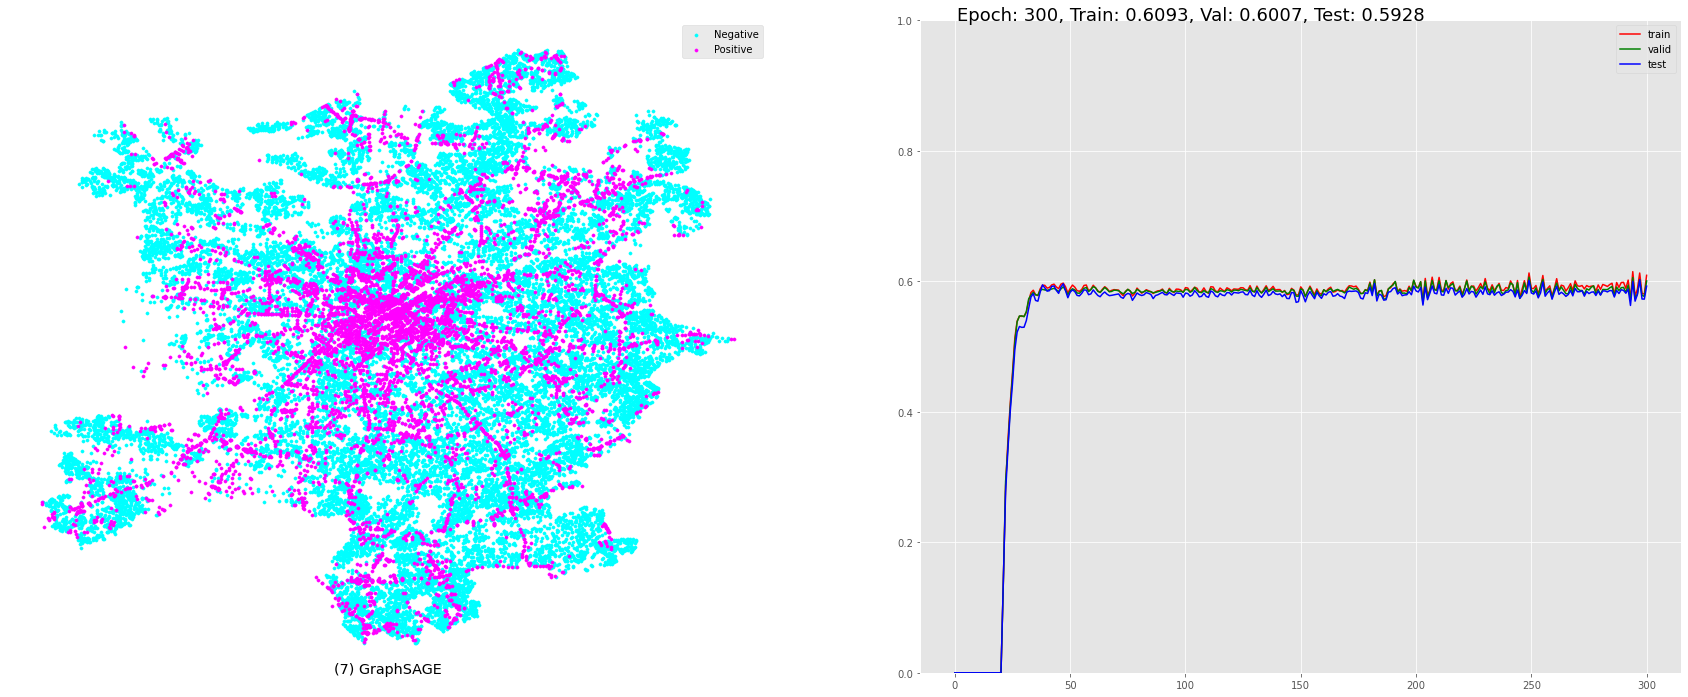

Selected epoch 249
F1 0.60167 | AUC 0.81100 | Test Acc 0.77256 | MAP 0.68834
Execution time: 14.9500 seconds


In [18]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, dim=d):
        super(GraphSAGE, self).__init__()
        self.conv1 = pyg_nn.SAGEConv(dataset.num_features, dim)
        self.conv2 = pyg_nn.SAGEConv(dim, dim*2, normalize=True)
        self.fc1 = nn.Linear(dim*2, dataset.num_classes)

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


cnt += 1
start_time = time.time()
model = GraphSAGE().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'GraphSAGE')
t = round(time.time() - start_time, 2)
all_res.append(('GraphSAGE',) + res + (t,))
print("Execution time: %.4f seconds" % t)

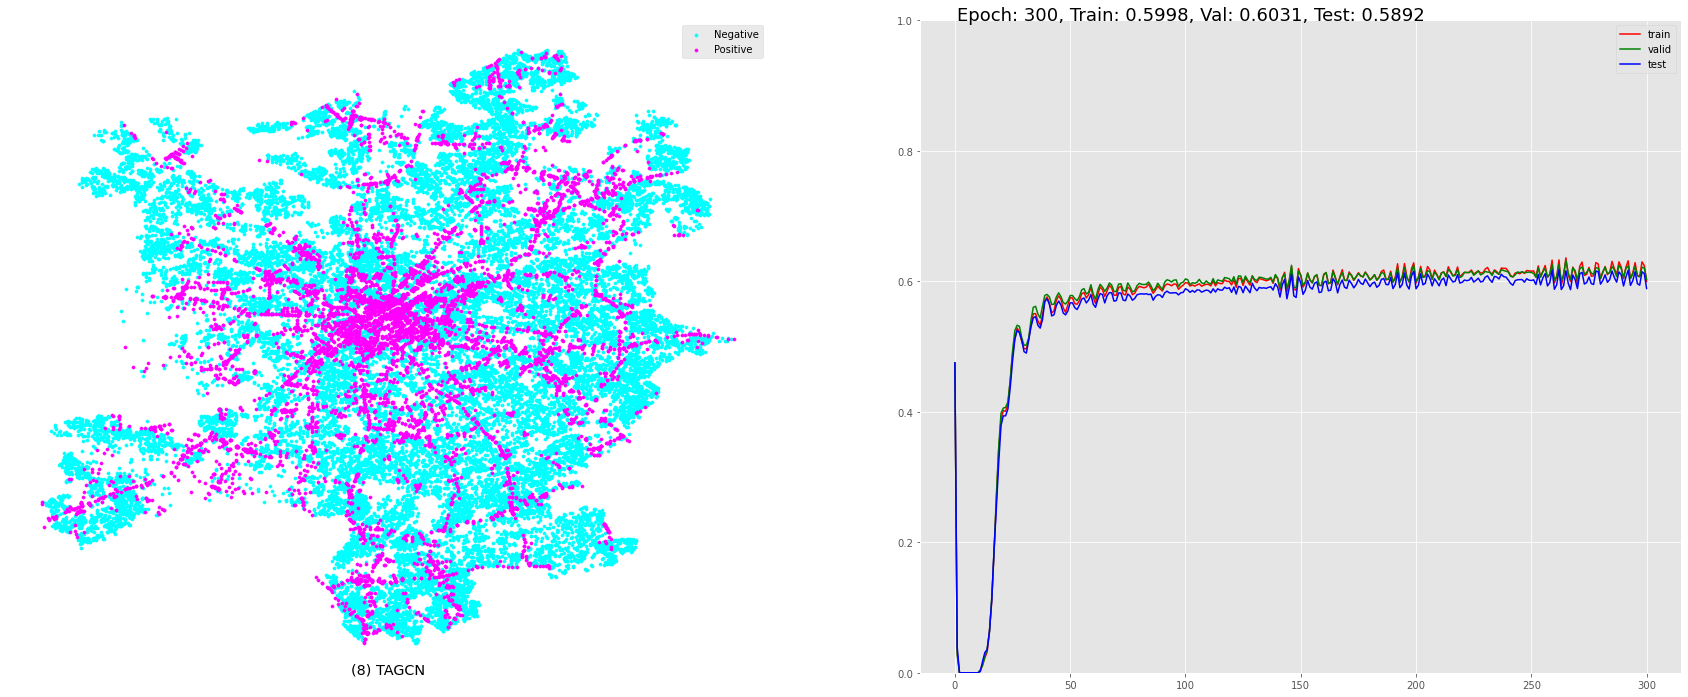

Selected epoch 265
F1 0.61644 | AUC 0.81774 | Test Acc 0.77205 | MAP 0.68355
Execution time: 16.7500 seconds


In [19]:
class TAGCN(torch.nn.Module):
    def __init__(self, hidden_dim=d):
        super(TAGCN, self).__init__()
        self.conv1 = pyg_nn.TAGConv(dataset.num_features, hidden_dim)
        self.conv2 = pyg_nn.TAGConv(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, dataset.num_classes)

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


cnt += 1
start_time = time.time()
model = TAGCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'TAGCN')
t = round(time.time() - start_time, 2)
all_res.append(('TAGCN',) + res + (t,))
print("Execution time: %.4f seconds" % t)

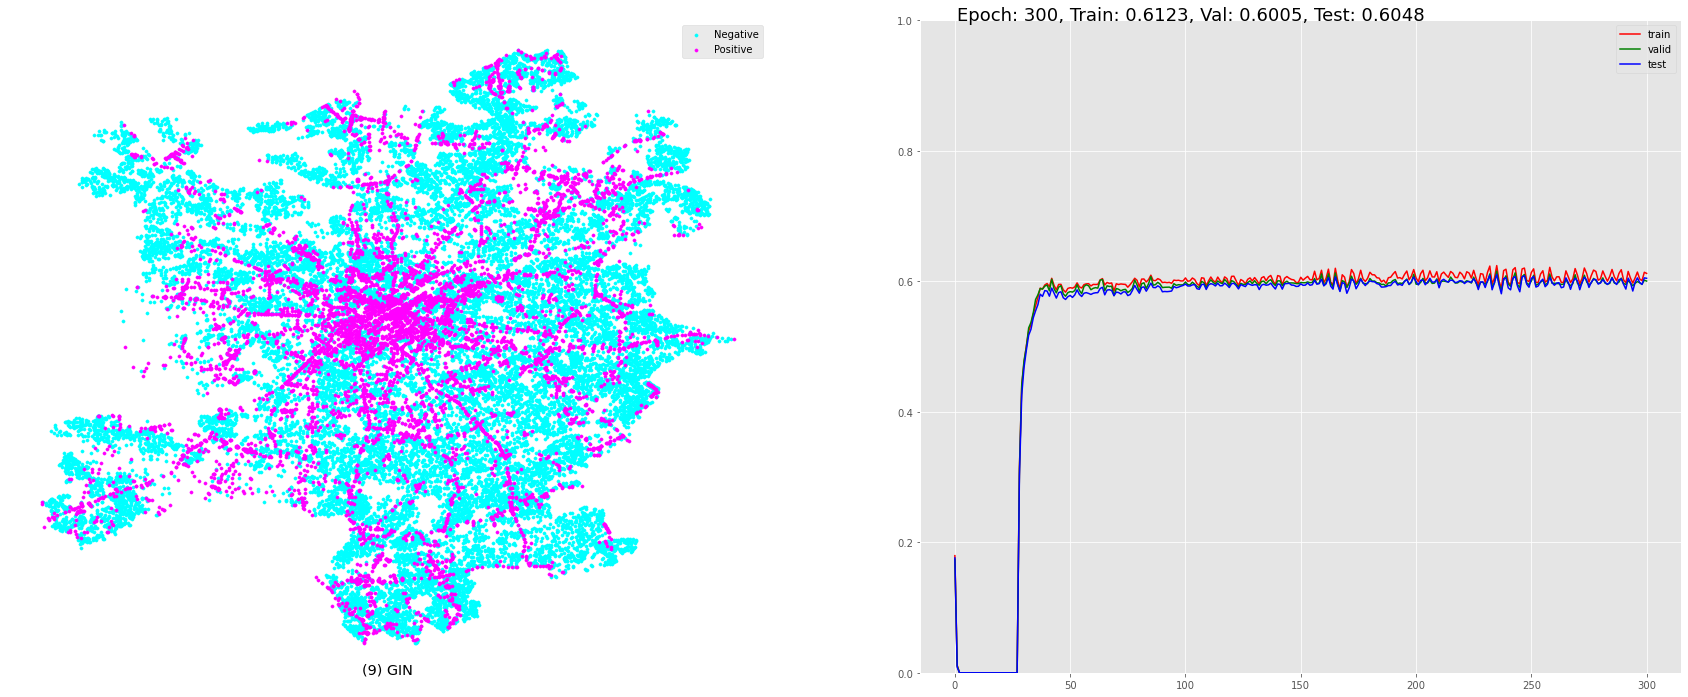

Selected epoch 235
F1 0.61082 | AUC 0.80766 | Test Acc 0.77222 | MAP 0.67591
Execution time: 14.4700 seconds


In [20]:
class GIN(torch.nn.Module):
    def __init__(self, dim=d):
        super(GIN, self).__init__()
        nn1 = nn.Sequential(nn.Linear(dataset.num_features, dim*2), nn.ReLU(), nn.Linear(dim*2, dim))
        nn2 = nn.Sequential(nn.Linear(dim, dim*2), nn.ReLU(), nn.Linear(dim*2, dim))
        self.conv1 = pyg_nn.GINConv(nn1)
        self.conv2 = pyg_nn.GINConv(nn2)
        self.fc1 = nn.Linear(dim, dataset.num_classes)

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


cnt += 1
start_time = time.time()
model = GIN().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'GIN')
t = round(time.time() - start_time, 2)
all_res.append(('GIN',) + res + (t,))
print("Execution time: %.4f seconds" % t)

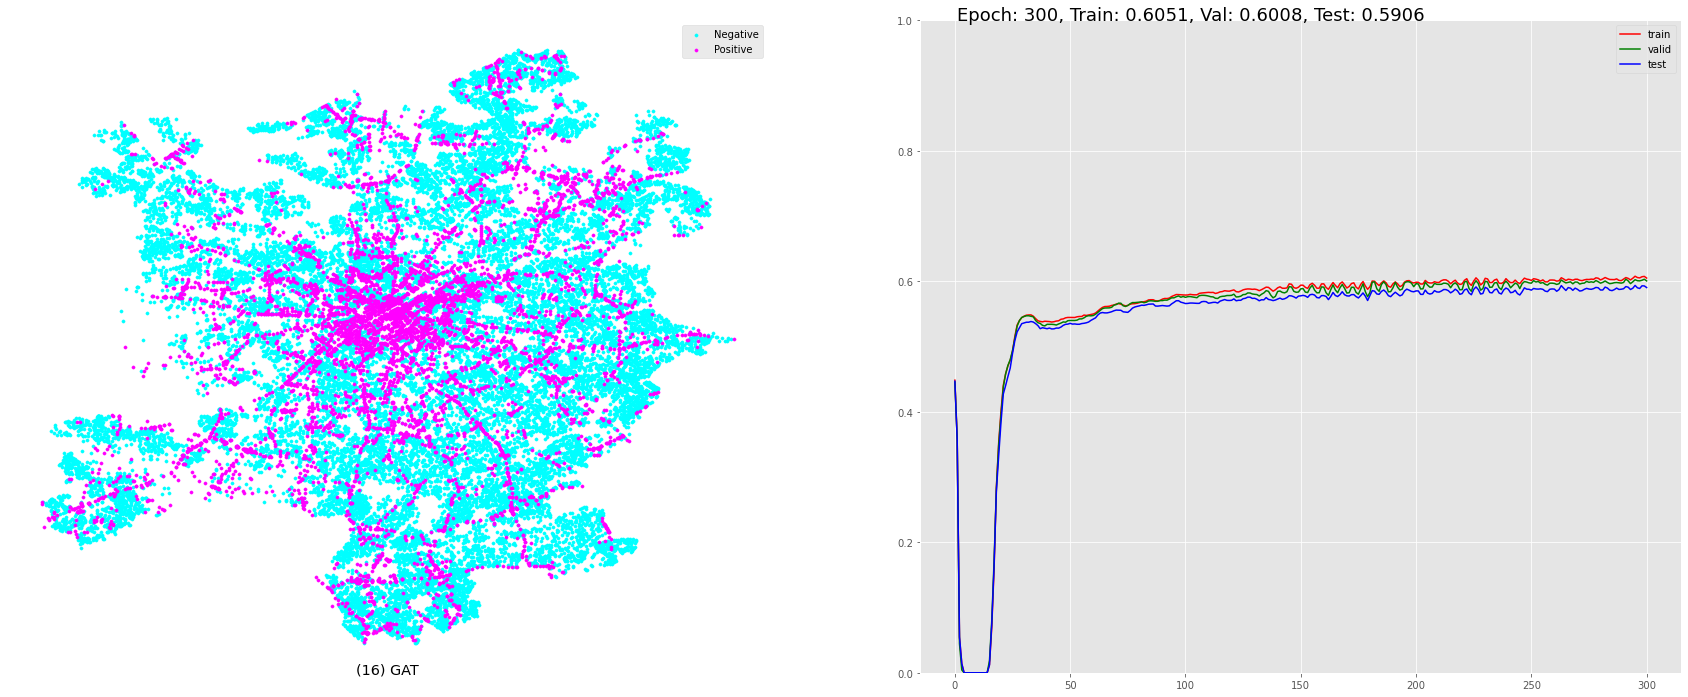

Selected epoch 291
F1 0.59213 | AUC 0.81143 | Test Acc 0.77954 | MAP 0.68005
Execution time: 17.7800 seconds


In [28]:
class GAT(torch.nn.Module):
    def __init__(self, dim=d):
        super(GAT, self).__init__()
        self.conv1 = pyg_nn.GATConv(dataset.num_features, dim, edge_dim=edge_attr_all.shape[1]) 
        self.conv2 = pyg_nn.GATConv(dim, dim, edge_dim=edge_attr_all.shape[1]) 
        self.fc1 = nn.Linear(dim, dataset.num_classes)

    def forward(self):
        x, edge_index, edge_attr = data.x, data.edge_index, edge_attr_all
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


cnt += 1
start_time = time.time()
model = GAT().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'GAT')
t = round(time.time() - start_time, 2)
all_res.append(('GAT',) + res + (t,))
print("Execution time: %.4f seconds" % t)

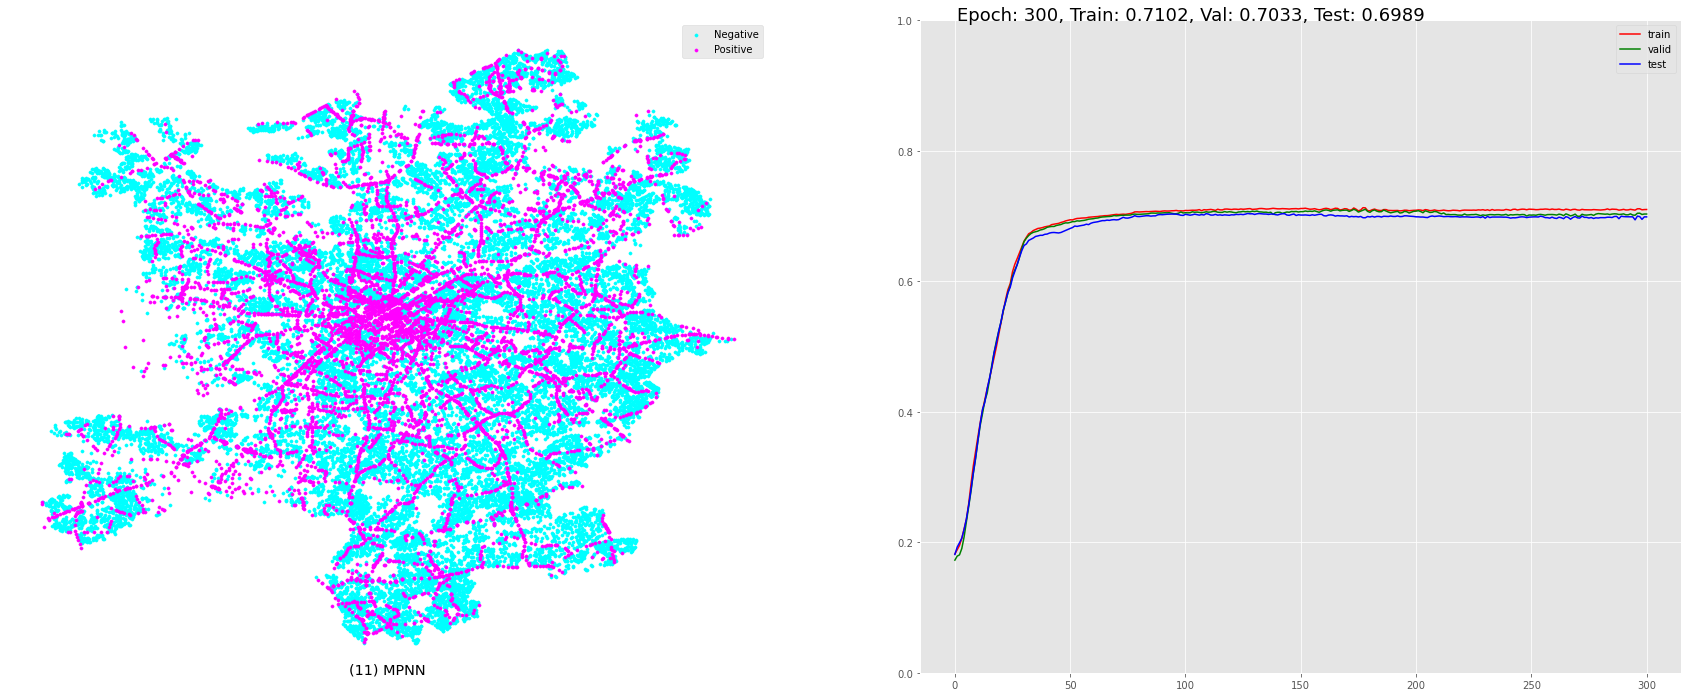

Selected epoch 178
F1 0.69759 | AUC 0.84912 | Test Acc 0.82244 | MAP 0.76859
Execution time: 21.4000 seconds


In [22]:
class MPNN(torch.nn.Module):
    def __init__(self, dim=d):
        super(MPNN, self).__init__()
        nn1 = nn.Sequential(nn.Linear(edge_attr_all.shape[1], 16), nn.ReLU(), nn.Linear(16, dataset.num_features*dim))
        self.conv1 = pyg_nn.NNConv(dataset.num_features, dim, nn1)
        nn2 = nn.Sequential(nn.Linear(edge_attr_all.shape[1], 16), nn.ReLU(), nn.Linear(16, dim*dim))
        self.conv2 = pyg_nn.NNConv(dim, dim, nn2)
        self.fc1 = nn.Linear(dim, dataset.num_classes)

    def forward(self):
        x, edge_index, edge_attr = data.x, data.edge_index, edge_attr_all #data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


cnt += 1
start_time = time.time()
model = MPNN().to(device)  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'MPNN')
t = round(time.time() - start_time, 2)
all_res.append(('MPNN',) + res + (t,))
print("Execution time: %.4f seconds" % t)

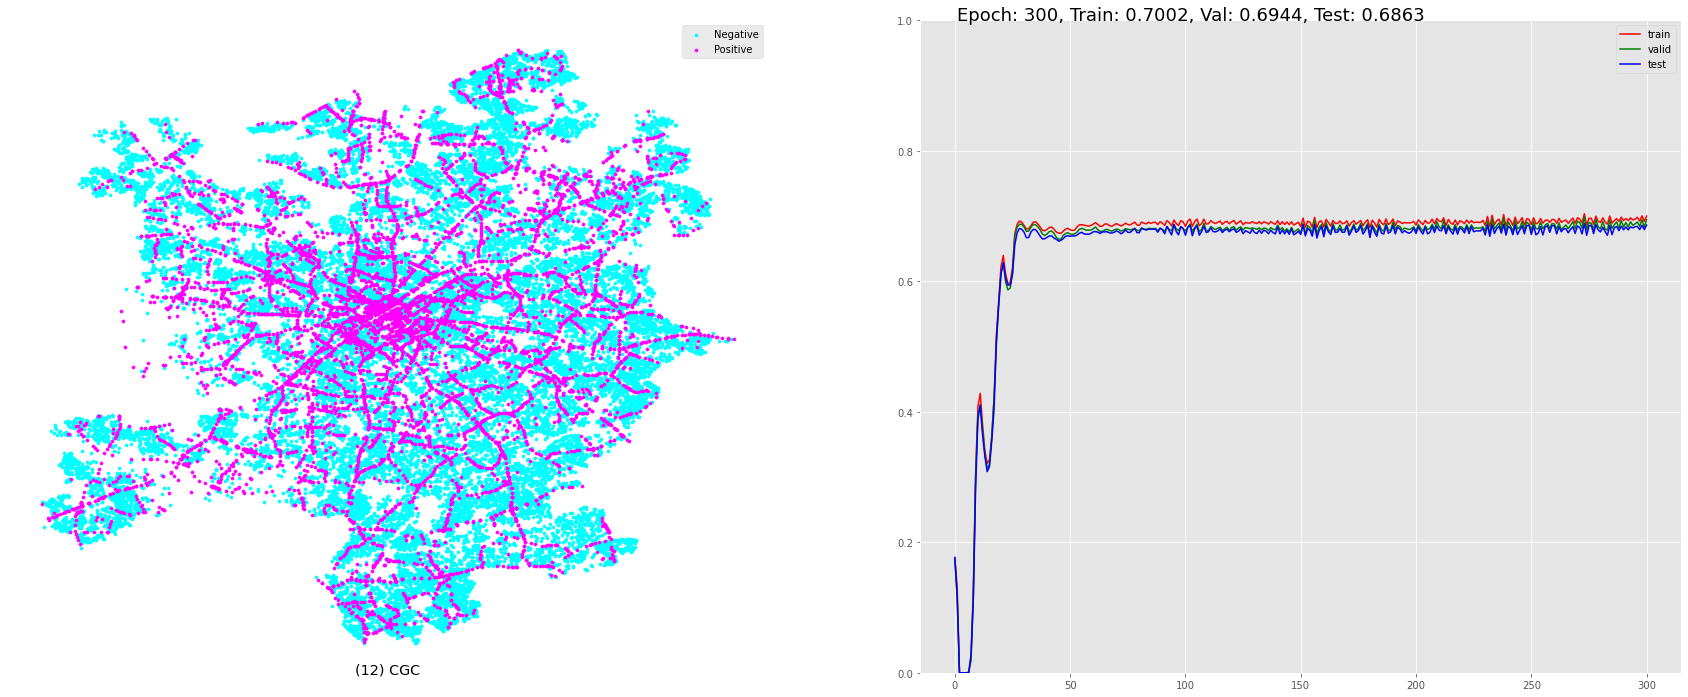

Selected epoch 273
F1 0.68907 | AUC 0.85694 | Test Acc 0.82039 | MAP 0.75958
Execution time: 15.7500 seconds


In [23]:
class CGC(torch.nn.Module):
    def __init__(self, dim=d):
        super(CGC, self).__init__()
        self.conv1 = pyg_nn.CGConv(dataset.num_features, edge_attr_all.size(-1))
        self.conv2 = pyg_nn.CGConv(dataset.num_features, edge_attr_all.size(-1)) 
        self.fc1 = nn.Linear(dataset.num_features, dataset.num_classes)

    def forward(self):
        x, edge_index, edge_attr = data.x, data.edge_index, edge_attr_all
        x = F.relu(self.conv1(x, edge_index, edge_attr)) # 
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = self.fc1(x)
        return F.log_softmax(x, dim=-1)


cnt += 1
start_time = time.time()
model = CGC().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'CGC')
t = round(time.time() - start_time, 2)
all_res.append(('CGC',) + res + (t,))
print("Execution time: %.4f seconds" % t)

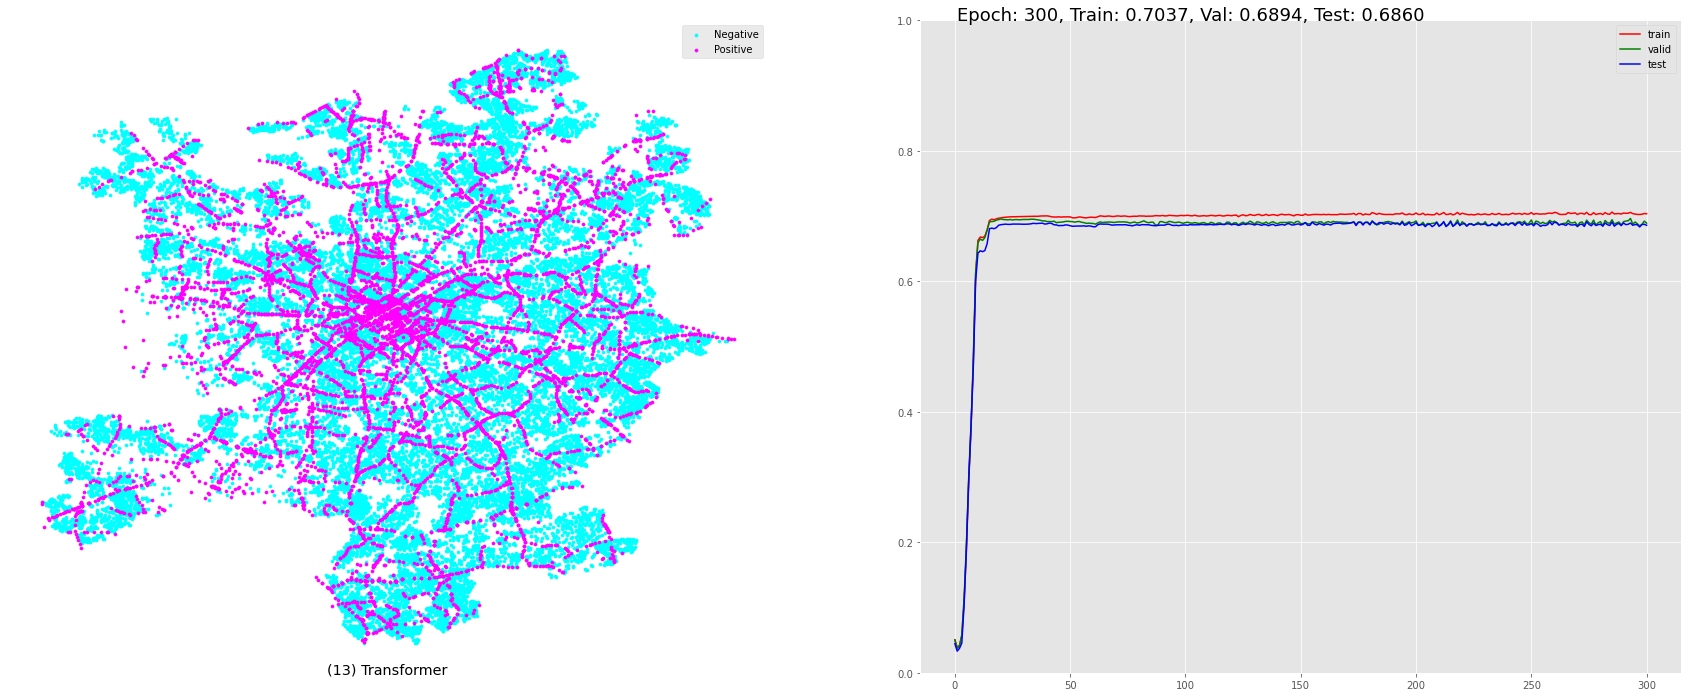

Selected epoch 293
F1 0.68947 | AUC 0.86301 | Test Acc 0.82686 | MAP 0.77880
Execution time: 18.4100 seconds


In [24]:
class GraphTransformer(torch.nn.Module):
    def __init__(self, dim=d):
        super(GraphTransformer, self).__init__()
        self.conv1 = pyg_nn.TransformerConv(dataset.num_features, dim, edge_dim=edge_attr_all.shape[1]) 
        self.conv2 = pyg_nn.TransformerConv(dim, dim, edge_dim=edge_attr_all.shape[1]) 
        self.fc1 = nn.Linear(dim, dataset.num_classes)

    def forward(self):
        x, edge_index, edge_attr = data.x, data.edge_index, edge_attr_all
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


cnt += 1
start_time = time.time()
model = GraphTransformer().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'Transformer')
t = round(time.time() - start_time, 2)
all_res.append(('Transformer',) + res + (t,))
print("Execution time: %.4f seconds" % t)

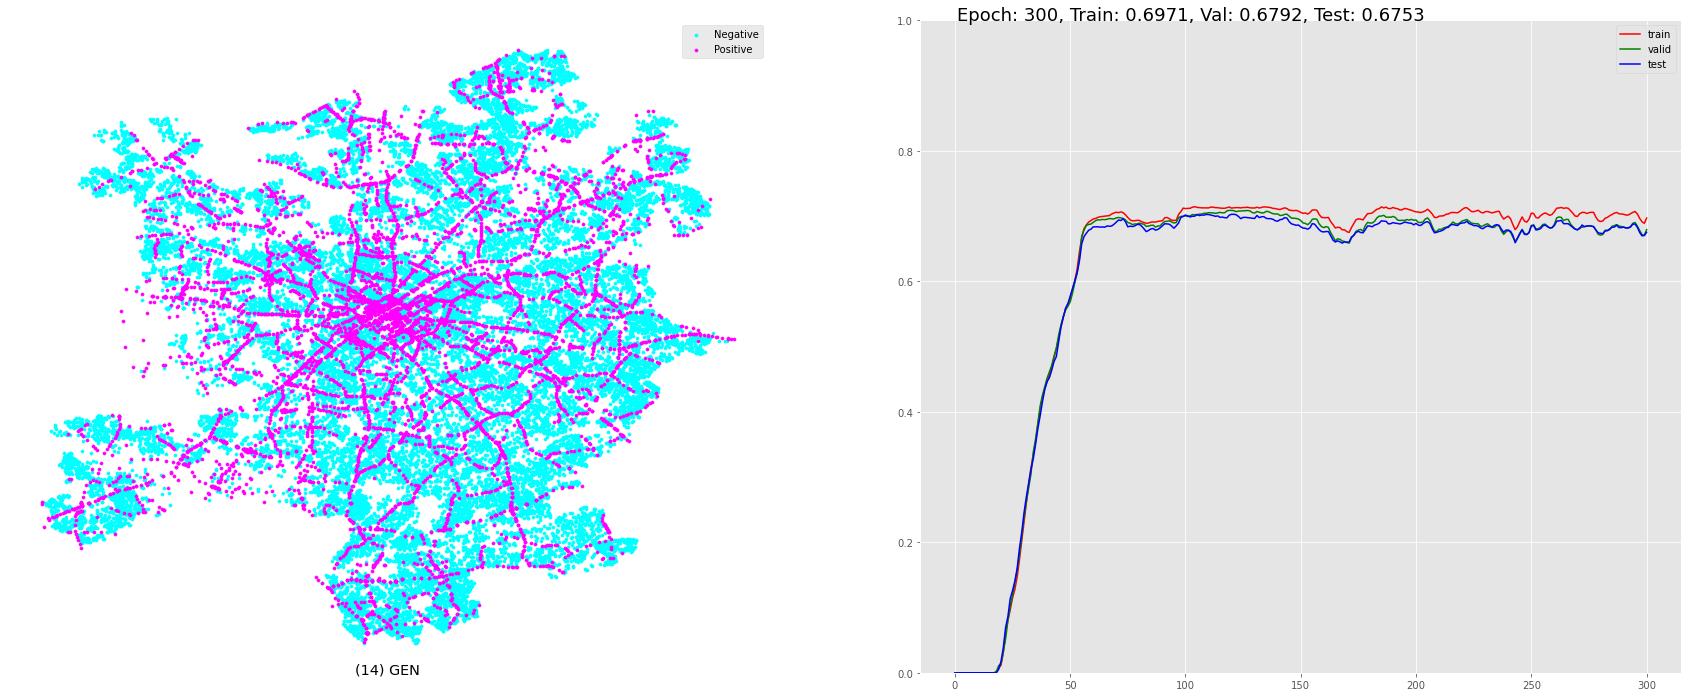

Selected epoch 186
F1 0.69238 | AUC 0.86010 | Test Acc 0.82210 | MAP 0.76509
Execution time: 18.9700 seconds


In [25]:
class GEN(torch.nn.Module):
    def __init__(self, dim=d):
        super(GEN, self).__init__()
        self.node_encoder = nn.Linear(data.x.size(-1), dim)
        self.edge_encoder = nn.Linear(edge_attr_all.size(-1), dim)
        self.conv1 = pyg_nn.GENConv(dim, dim) 
        self.conv2 = pyg_nn.GENConv(dim, dim)
        self.fc1 = nn.Linear(dim, dataset.num_classes)

    def forward(self):
        x, edge_index, edge_attr = self.node_encoder(data.x), data.edge_index, self.edge_encoder(edge_attr_all)
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

    
cnt += 1
start_time = time.time()
model = GEN().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'GEN')
t = round(time.time() - start_time, 2)
all_res.append(('GEN',) + res + (t,))
print("Execution time: %.4f seconds" % t)

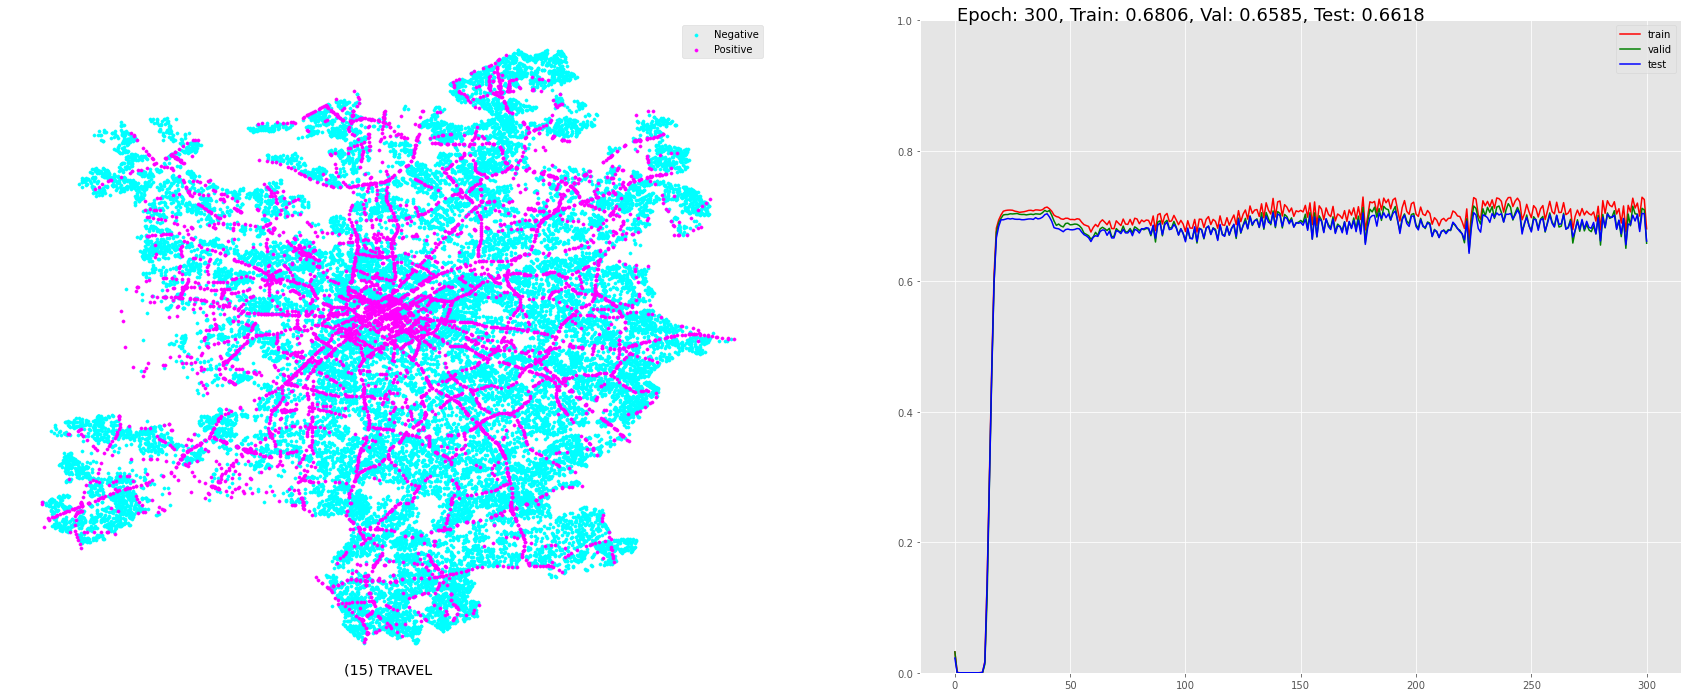

Selected epoch 240
F1 0.70281 | AUC 0.86376 | Test Acc 0.81614 | MAP 0.77748
Execution time: 21.0300 seconds


In [26]:
# Note that directional and angular edge features are precomputed in our datasets
edge_attr1 = np.concatenate((data.edge_attr.cpu(), data.edge_attr_dir.cpu()), axis=1) # directional component
edge_attr2 = np.concatenate((data.edge_attr.cpu(), data.edge_attr_ang.cpu()), axis=1) # angular component
edge_attr1 = StandardScaler().fit_transform(edge_attr1)
edge_attr2 = StandardScaler().fit_transform(edge_attr2)
data.edge_attr1 = torch.tensor(edge_attr1).float().to(device)
data.edge_attr2 = torch.tensor(edge_attr2).float().to(device)
num_edge_features1 = data.edge_attr1.shape[1]
num_edge_features2 = data.edge_attr2.shape[1]


class TRAVELNet(torch.nn.Module):
    def __init__(self, dim=d):
        super(TRAVELNet, self).__init__()
        convdim = 8
        x = 16
        self.node_encoder = nn.Sequential(nn.Linear(data.x.size(-1), x), nn.LeakyReLU(), nn.Linear(x, x))
        self.edge_encoder1 = nn.Sequential(nn.Linear(data.edge_attr1.size(-1), x), nn.LeakyReLU(), nn.Linear(x, x))
        self.edge_encoder2 = nn.Sequential(nn.Linear(data.edge_attr2.size(-1), x), nn.LeakyReLU(), nn.Linear(x, x))
        nn1 = nn.Sequential(nn.Linear(x + x, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, convdim))
        self.conv1 = TRAVELConv(x, convdim, nn1)
        nn2 = nn.Sequential(nn.Linear(2*convdim + x, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, dataset.num_classes))
        self.conv2 = TRAVELConv(2*convdim, dataset.num_classes, nn2)
        self.bn1 = nn.BatchNorm1d(convdim*2)
        nn1_2 = nn.Sequential(nn.Linear(x + x, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, convdim))
        self.conv1_2 = TRAVELConv(x, convdim, nn1_2)
        nn2_2 = nn.Sequential(nn.Linear(2*convdim + x, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, dataset.num_classes))
        self.conv2_2 = TRAVELConv(2*convdim, dataset.num_classes, nn2_2)
        self.bn2 = nn.BatchNorm1d(dataset.num_classes*2)
        self.fc = nn.Linear(dataset.num_classes*2, dataset.num_classes)

    def forward(self):
        x, edge_index = self.node_encoder(data.x), data.edge_index
        edge_attr1, edge_attr2 = self.edge_encoder1(data.edge_attr1), self.edge_encoder2(data.edge_attr2)
        x1 = F.relu(self.conv1(x, edge_index, edge_attr1))
        x2 = F.relu(self.conv1_2(x, edge_index, edge_attr2))
        x = torch.cat((x1, x2), axis=1)
        x = self.bn1(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x1 = F.relu(self.conv2(x, edge_index, edge_attr1))
        x2 = F.relu(self.conv2_2(x, edge_index, edge_attr2))
        x = torch.cat((x1, x2), axis=1)
        # x = self.bn2(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    
cnt += 1
start_time = time.time()
model = TRAVELNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.006, weight_decay=5e-4)
res = train_loop(model, data, optimizer, num_epochs, 'TRAVEL')
t = round(time.time() - start_time, 2)
all_res.append(('TRAVEL',) + res + (t,))
print("Execution time: %.4f seconds" % t)

In [34]:
results = pd.DataFrame(all_res, columns=['Method', 'F1', 'AUC', 'Acc', 'MAP', 'Time'])
results

Method      F1     AUC     Acc     MAP   Time
0       XGBoost  0.4489  0.6295  0.7375  0.4273   0.37
1           MLP  0.4489  0.7368  0.7375  0.5268  18.07
2           GCN  0.5744  0.8041  0.7739  0.6667  15.59
3       ChebNet  0.5907  0.8104  0.7787  0.6821  16.14
4       ARMANet  0.6037  0.8122  0.7792  0.6856  14.96
5     GraphSAGE  0.6017  0.8110  0.7726  0.6883  14.95
6         TAGCN  0.6164  0.8177  0.7720  0.6835  16.75
7           GIN  0.6108  0.8077  0.7722  0.6759  14.47
8           GAT  0.5921  0.8114  0.7795  0.6801  17.78
9          MPNN  0.6976  0.8491  0.8224  0.7686  21.40
10          CGC  0.6891  0.8569  0.8204  0.7596  15.75
11  Transformer  0.6895  0.8630  0.8269  0.7788  18.41
12          GEN  0.6924  0.8601  0.8221  0.7651  18.97
13       TRAVEL  0.7028  0.8638  0.8161  0.7775  21.03